# Lung Sound Analysis for Respiratory Health

In [ ]:
## Import necessary libraries
import os
import re
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy.io import wavfile
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import xgboost as xgb
from xgboost import XGBClassifier

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Part 1: Data Loading and Exploratory Analysis

In [ ]:
# A. Download and extract the dataset
url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/jwyy9np4gv-3.zip"
!wget -O dataset.zip {url}

with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

with zipfile.ZipFile("Audio Files.zip", 'r') as zip_ref:
    zip_ref.extractall("Audio Files")

with zipfile.ZipFile("Stethoscope Files.zip", 'r') as zip_ref:
    zip_ref.extractall("Stethoscope Files")

# List of files
print("Files on 'Audio Files':", os.listdir("Audio Files"))
print("Filoes on 'Stethoscope Files':", os.listdir("Stethoscope Files"))

--2025-02-05 20:39:40--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/jwyy9np4gv-3.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.66.110, 3.5.67.153, 3.5.68.146, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.66.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68697388 (66M) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  65.51M  14.6MB/s    in 5.9s    

2025-02-05 20:39:47 (11.2 MB/s) - ‘dataset.zip’ saved [68697388/68697388]

Files on 'Audio Files': ['EP23_Lung Fibrosis,Crep,P R L ,50,M.wav', 'BP50_N,N,P R L ,27,M.wav', 'DP22_BRON,Crep,P R U,24,M.wav', 'EP38_Asthma,E W,P R M,38,M.wav', 'BP87_N,N,P R M,72,M.wav', 'EP28_BRON,Crep,P L U,68,F.wav', 'DP69_pneumonia,Bronchial,P R L ,64,M.wav', 'BP

In [ ]:
#Loading Data Annotations as Diagnosis Data
diagnosis_data = pd.read_excel('/content/Data annotation.xlsx',header=0,usecols=range(5), names=['Age','Gender','Location','Sound type','Diagnosis'])
diagnosis_data.head()
print(diagnosis_data.head())

    Age Gender Location Sound type                       Diagnosis
0  70.0      M    P L L      I E W                          Asthma
1  52.0      F   P L L         E W                          Asthma
2  50.0      F   P L L       I E W                          Asthma
3  72.0      F   P R L         I C  Heart Failure + Lung Fibrosis 
4  71.0      M   P R L     I C E W            Heart Failure + COPD


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Asthma'),
  Text(1, 0, 'Heart Failure + Lung Fibrosis '),
  Text(2, 0, 'Heart Failure + COPD'),
  Text(3, 0, 'Plueral Effusion'),
  Text(4, 0, 'Heart Failure'),
  Text(5, 0, 'heart failure'),
  Text(6, 0, 'COPD'),
  Text(7, 0, 'pneumonia'),
  Text(8, 0, 'Asthma and lung fibrosis'),
  Text(9, 0, 'BRON'),
  Text(10, 0, 'Lung Fibrosis'),
  Text(11, 0, 'copd'),
  Text(12, 0, 'asthma'),
  Text(13, 0, 'N')])

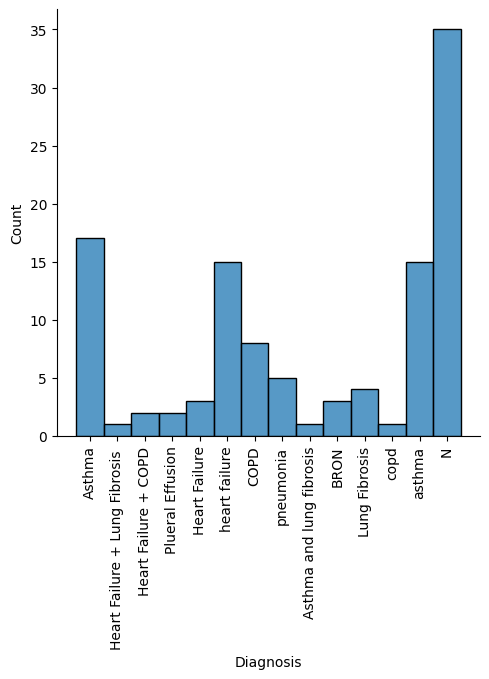

In [ ]:
sns.displot(diagnosis_data.Diagnosis) #sns.countplot(x='Disease', data=diagnosis_data)
plt.xticks(rotation=90)

In [ ]:
print (diagnosis_data.Diagnosis.value_counts())

Diagnosis
N                                 35
Asthma                            17
heart failure                     15
asthma                            15
COPD                               8
pneumonia                          5
Lung Fibrosis                      4
Heart Failure                      3
BRON                               3
Heart Failure + COPD               2
Plueral Effusion                   2
Heart Failure + Lung Fibrosis      1
Asthma and lung fibrosis           1
copd                               1
Name: count, dtype: int64


In [ ]:
print(diagnosis_data.columns)

Index(['Age', 'Gender', 'Location', 'Sound type', 'Diagnosis'], dtype='object')


In [ ]:
# Diagnosis frequency
print(diagnosis_data.Diagnosis.value_counts())

Diagnosis
N                                 35
Asthma                            17
heart failure                     15
asthma                            15
COPD                               8
pneumonia                          5
Lung Fibrosis                      4
Heart Failure                      3
BRON                               3
Heart Failure + COPD               2
Plueral Effusion                   2
Heart Failure + Lung Fibrosis      1
Asthma and lung fibrosis           1
copd                               1
Name: count, dtype: int64


In [ ]:
##N Example
import IPython.display as ipd
x=librosa.load("/content/Audio Files/BP100_N,N,P R M,70,F.wav")
ipd.Audio("/content/Audio Files/BP100_N,N,P R M,70,F.wav")

In [ ]:
##Asthma Example
import IPython.display as ipd
x=librosa.load("/content/Audio Files/BP101_Asthma,E W,P L M,12,F.wav")
ipd.Audio("/content/Audio Files/BP101_Asthma,E W,P L M,12,F.wav")

In [ ]:
##Heart Failure  Example
import IPython.display as ipd
x=librosa.load("/content/Audio Files/BP11_Heart Failure,C,P L L,53,M.wav")
ipd.Audio("/content/Audio Files/BP11_Heart Failure,C,P L L,53,M.wav")


In [ ]:
# Function to extract filenames and construct labels
def extract_labels(file_path):
    labels = []
    for root, dirs, files in os.walk(file_path):
        for file in files:
            if file.endswith(".wav"):
                match = re.match(r"(.*?)_(.*?),(.*?),(.*?),(.*?),(.*?)\.wav", file)
                if match:
                    filter_type, diagnosis, location, acquisition_mode, age, sex = match.groups()
                    labels.append([file, filter_type, diagnosis, location, acquisition_mode, age, sex])
                else:
                    print(f"Skipping file with unexpected format: {file}")
    return labels

# Extract labels from audio fileS
labels = extract_labels("Audio Files")
df_labels = pd.DataFrame(labels, columns=['Filename', 'Filter Type', 'Diagnosis', 'Location', 'Acquisition Mode', 'Age', 'Sex'])

# Merge with annotations
diagnosis_data["Patient Number"] = diagnosis_data.index.astype(str)  # Assuming you have a 'Patient Number' in diagnosis_data
df_labels["Patient Number"] = df_labels["Filename"].str.extract(r'(.*?)_')  # Extracting Patient Number from Filename

# Merge based on "Patient Number"
df_annotations = pd.merge(df_labels, diagnosis_data, on="Patient Number", how="left")  # Use 'how="left"' to keep all data from df_labels

                         Diagnosis  Absolute Frequency  Relative Frequency
0                                N                 105            0.312500
1                           Asthma                  51            0.151786
2                           asthma                  45            0.133929
3                    heart failure                  45            0.133929
4                             COPD                  24            0.071429
5                        pneumonia                  15            0.044643
6                    Lung Fibrosis                  12            0.035714
7                             BRON                   9            0.026786
8                    Heart Failure                   9            0.026786
9                 Plueral Effusion                   6            0.017857
10            Heart Failure + COPD                   6            0.017857
11  Heart Failure + Lung Fibrosis                    3            0.008929
12        Asthma and lung

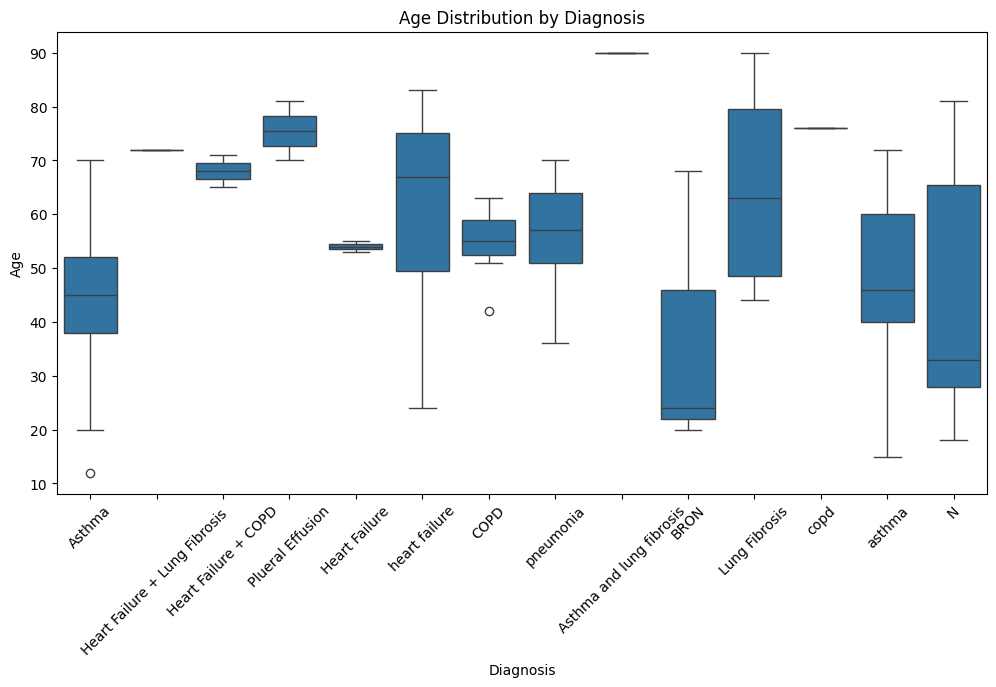

In [ ]:
# Diagnoses Frequencies Abs. and Relative
frequency_table = df_annotations["Diagnosis_x"].value_counts().reset_index()
frequency_table.columns = ["Diagnosis", "Absolute Frequency"]
frequency_table["Relative Frequency"] = frequency_table["Absolute Frequency"] / frequency_table["Absolute Frequency"].sum()
print(frequency_table)

# Boxplot of age by diagnosis (if 'Age' column is available)
if 'Age_x' in df_annotations.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Diagnosis", y="Age", data=diagnosis_data)#df_annotations)
    plt.title("Age Distribution by Diagnosis")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("La columna 'Age' no está disponible en el dataset.")


# Part 2: Signal Processing and Feature Engineering

In [ ]:
#wav example format: BP112_N,N,P L M,30,M.wa

In [ ]:
# A. Create a Python script to read WAV files and store relevant information
def read_wav_files(file_paths):
    wav_data = []
    for file_path in file_paths:
        sample_rate, audio_data = wavfile.read(file_path)
        wav_data.append({
            "path": file_path,
            "sample_rate": sample_rate,
            "audio_data": audio_data,
            "data_type": audio_data.dtype,
            "Filename": os.path.basename(file_path)  # Extract filename
        })
    return wav_data

file_paths = [os.path.join("/content/Audio Files", f) for f in os.listdir("/content/Audio Files") if f.endswith(".wav")]
wav_data = read_wav_files(file_paths)
df_wav = pd.DataFrame(wav_data)

# Merge with annotations using "Filename" column
df_wav = pd.merge(df_wav, df_annotations, on="Filename", how='left')
columns_to_drop = ['Age_y', 'Gender', 'Location_y', 'Sound type', 'Diagnosis_y']
df_wav = df_wav.drop(columns=columns_to_drop)


In [ ]:
# Overall Statistical Analysis
def calculate_statistics(row):
    audio_data = row['audio_data']
    sample_rate = row['sample_rate']
    return {
        "duration": len(audio_data) / sample_rate,
        "amplitude_mean": np.mean(audio_data),
        "amplitude_median": np.median(audio_data),
        "amplitude_std": np.std(audio_data),
        "amplitude_max": np.max(audio_data),
        "amplitude_min": np.min(audio_data),
        "zero_crossing_rate": np.sum(np.abs(np.diff(np.sign(audio_data)))) / len(audio_data),
        "energy": np.sum(np.square(audio_data))
    }

df_wav["statistics"] = df_wav.apply(calculate_statistics, axis=1)
df_statistics = pd.DataFrame(df_wav["statistics"].tolist())
df_wav = pd.concat([df_wav, df_statistics], axis=1)

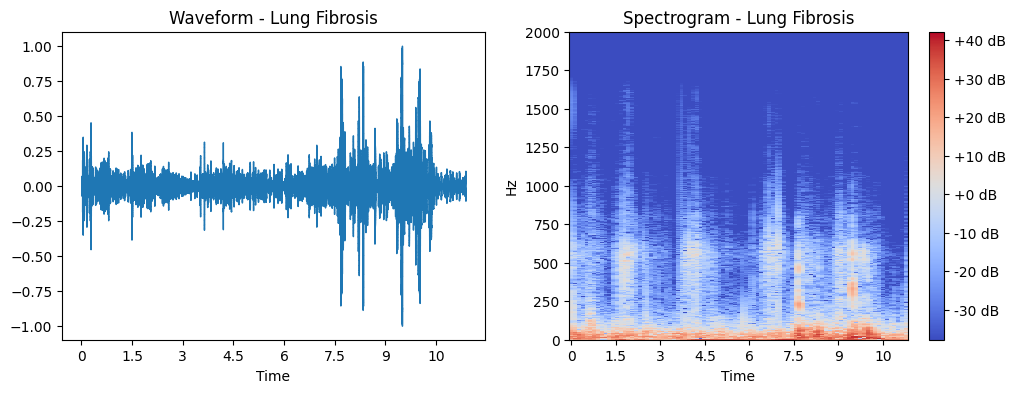

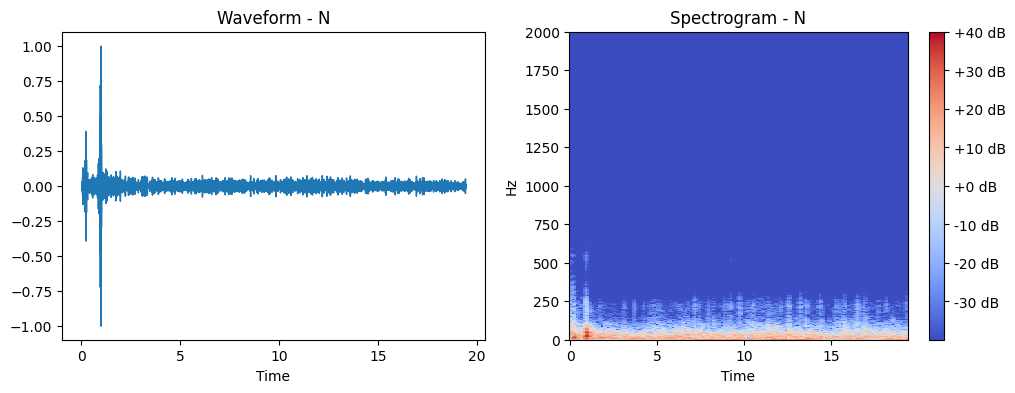

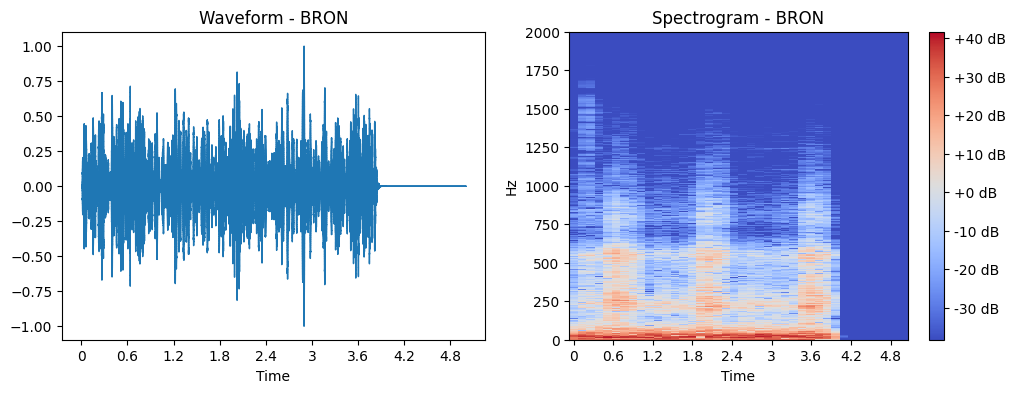

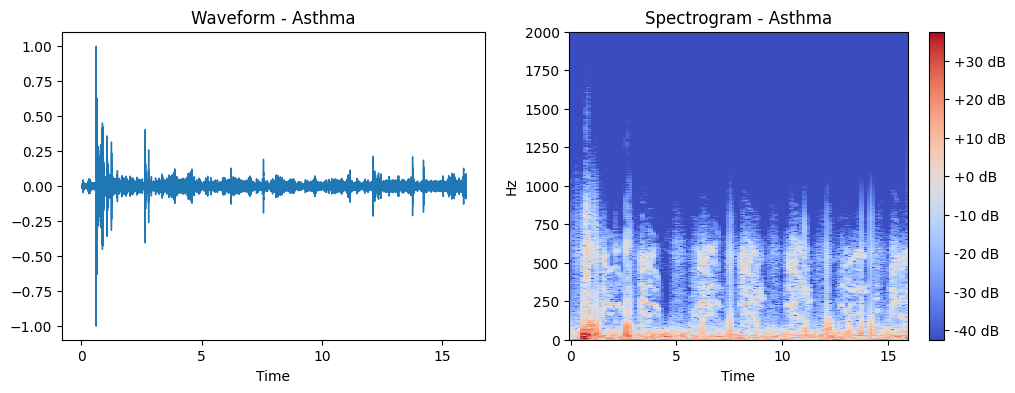

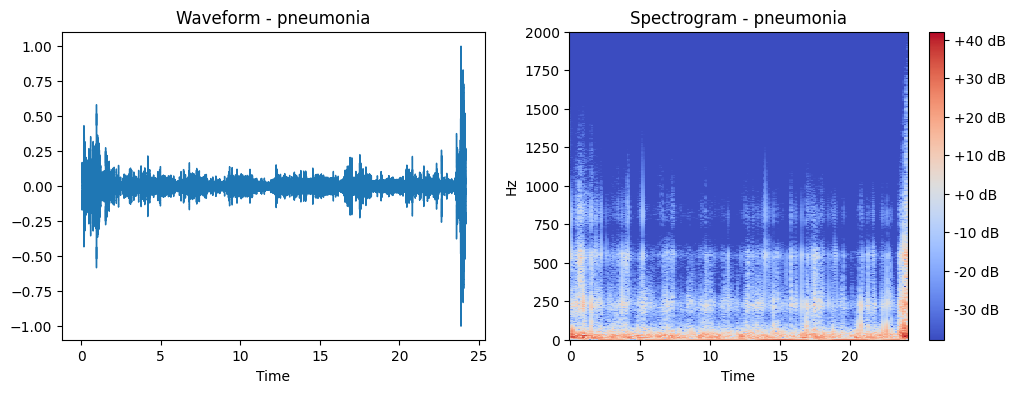

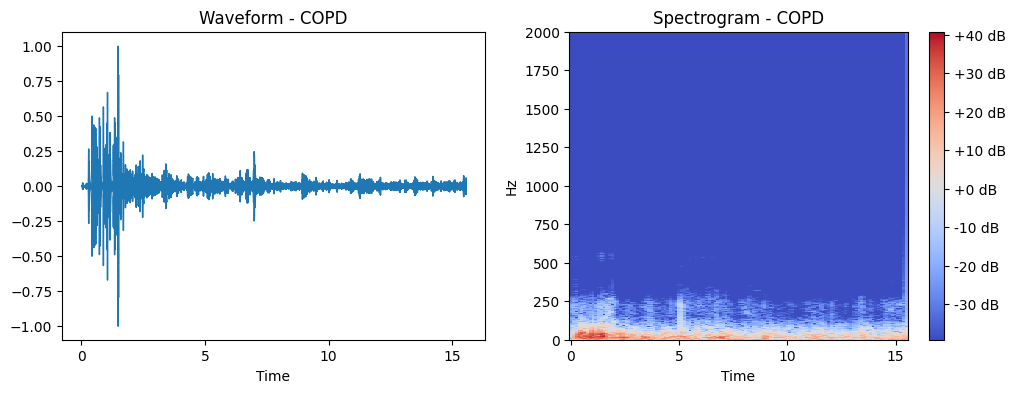

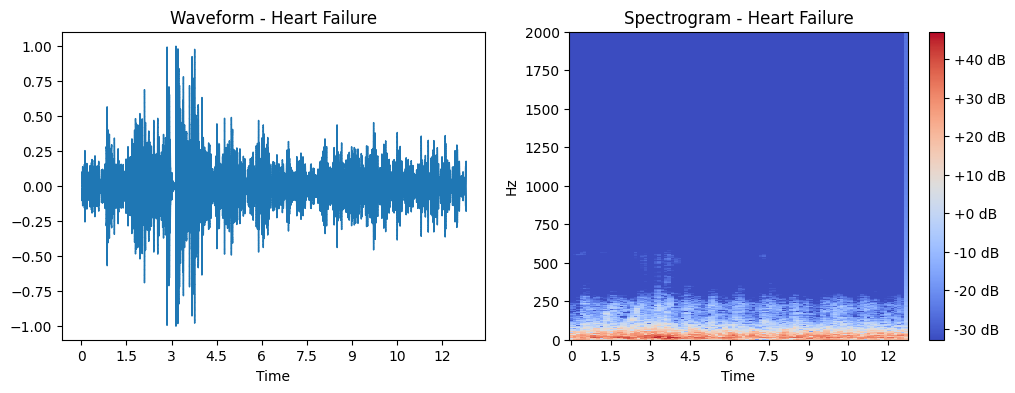

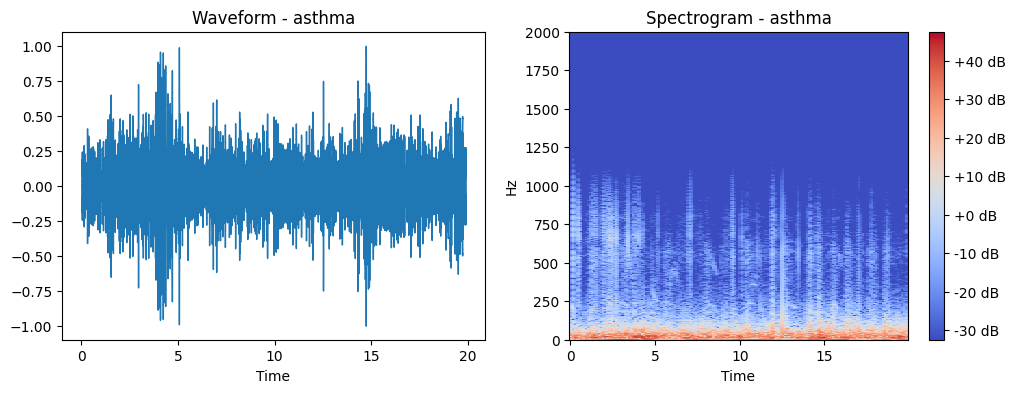

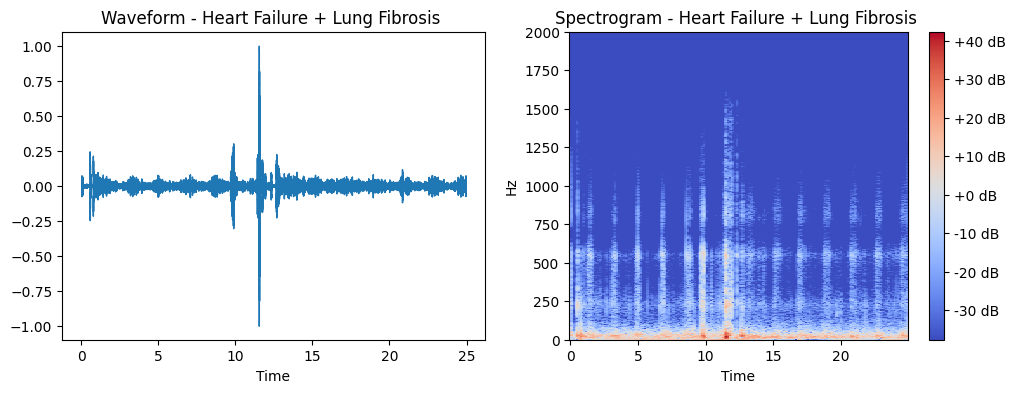

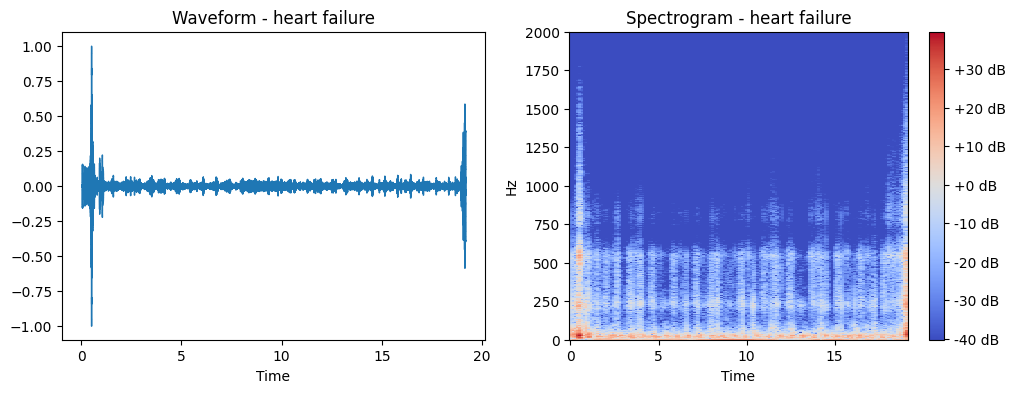

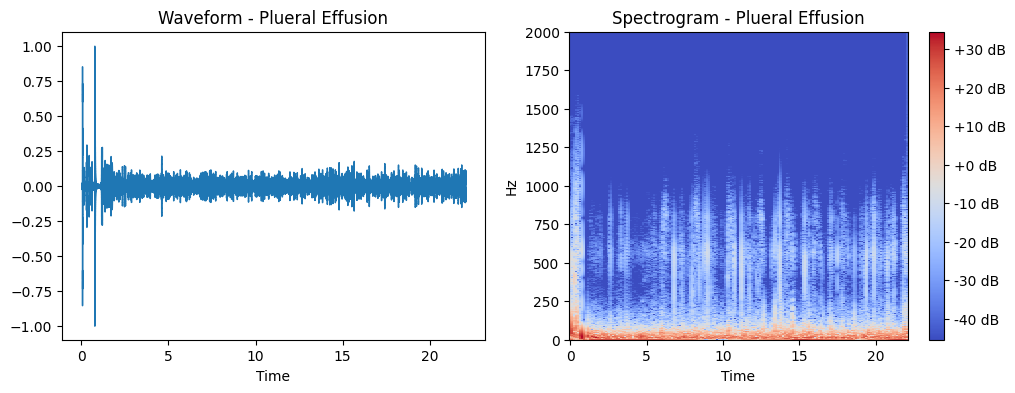

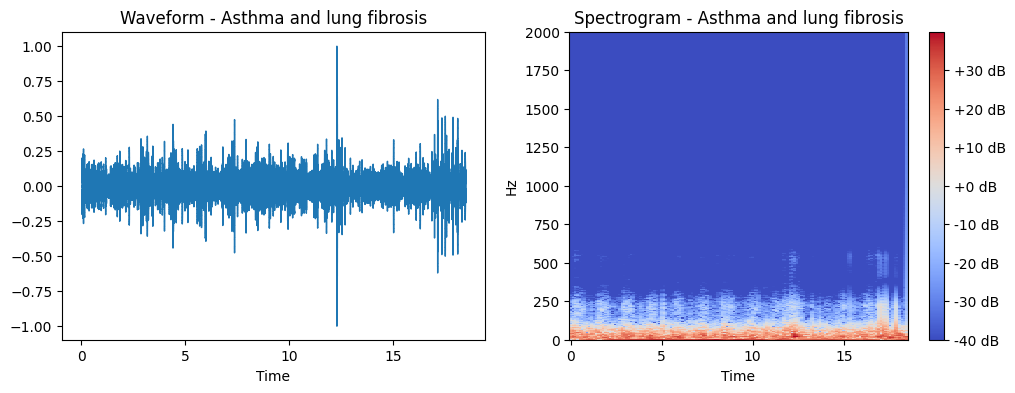

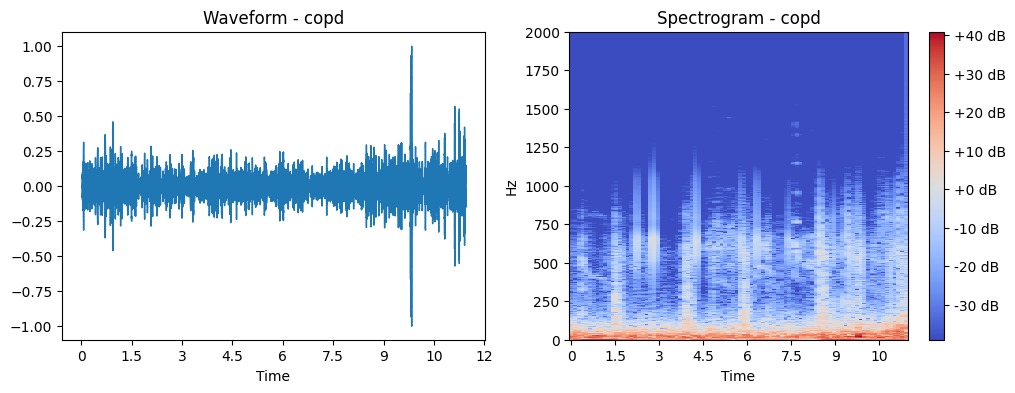

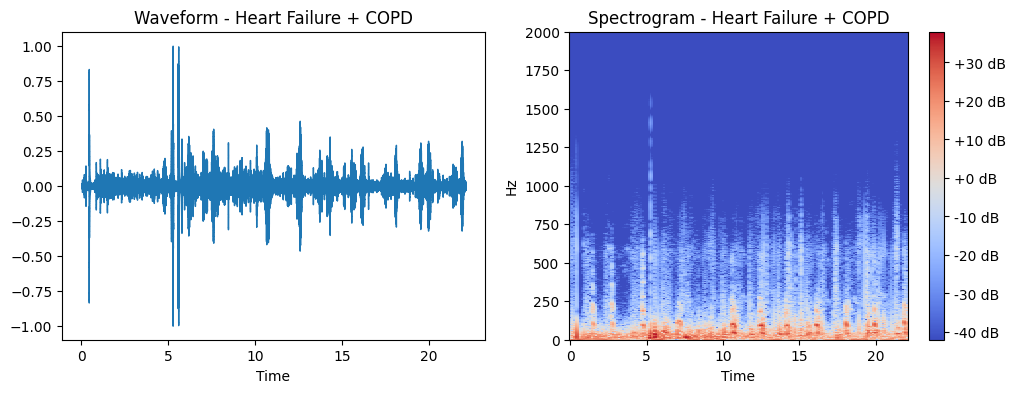

In [ ]:
# B. Plot spectrogram and time series waveform
def plot_spectrogram(audio_data, sample_rate, title):
    # Convert audio_data to floating-point
    audio_data_float = librosa.util.buf_to_float(audio_data)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(audio_data_float, sr=sample_rate)  # Use converted data
    plt.title(f"Waveform - {title}")
    plt.subplot(1, 2, 2)
    X = librosa.stft(audio_data_float)  # Use converted data
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spectrogram - {title}")
    plt.show()

for diagnosis in df_wav["Diagnosis_x"].unique():
    sample = df_wav[df_wav["Diagnosis_x"] == diagnosis].iloc[0]
    plot_spectrogram(sample["audio_data"], sample["sample_rate"], diagnosis)

In [ ]:
# C. Extract audio features
def extract_audio_features(audio_data, sample_rate):
     # Convert to floating point before analysis
    audio_data_float = librosa.util.buf_to_float(audio_data)


    mfccs = librosa.feature.mfcc(y=audio_data_float, sr=sample_rate, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=audio_data_float, sr=sample_rate)
    mel = librosa.feature.melspectrogram(y=audio_data_float, sr=sample_rate)
    contrast = librosa.feature.spectral_contrast(y=audio_data_float, sr=sample_rate, n_bands=6, fmin=50)
    #tonnetz = librosa.feature.tonnetz(y=audio_data_float, sr=sample_rate)#,n_bands=6, fmin=50)
    #tonnetz = librosa.feature.tonnetz(y=audio_data_float, sr=sample_rate, n_bins=72, fmin=librosa.note_to_hz('C1'))

    return {
        "mfccs_mean": np.mean(mfccs, axis=1),
        "chroma_mean": np.mean(chroma, axis=1),
        "mel_mean": np.mean(mel, axis=1),
        "contrast_mean": np.mean(contrast, axis=1),
        #"tonnetz_mean": np.mean(tonnetz, axis=1)
    }

df_wav["audio_features"] = df_wav.apply(lambda row: extract_audio_features(row["audio_data"], row["sample_rate"]), axis=1)
df_features = pd.DataFrame(df_wav["audio_features"].tolist())
df_wav = pd.concat([df_wav, df_features], axis=1)


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
# D. Normalize audio and extract MFCC features
def normalize_audio(audio_data):
    if not np.issubdtype(audio_data.dtype, np.floating):
        audio_data = librosa.util.buf_to_float(audio_data)
    return librosa.util.normalize(audio_data, axis=0)

df_wav["normalized_audio"] = df_wav["audio_data"].apply(normalize_audio)
df_wav["mfccs"] = df_wav.apply(lambda row: librosa.feature.mfcc(y=row["normalized_audio"], sr=row["sample_rate"], n_mfcc=13), axis=1)

# Part 3: AI Models: Machine Learning KNN,NN, XGBoost

In [ ]:

# 1. Determine max_len (time frames) and num_features:
max_len = 0
num_features = 0
for mfcc_seq in df_wav["mfccs"]:
    max_len = max(max_len, len(mfcc_seq))  # Get the number of time frames
    try:  # Handle cases where mfcc_seq might not have a shape attribute
        num_features = max(num_features, mfcc_seq.shape[1])
    except AttributeError:
        num_features = max(num_features, len(mfcc_seq[0]))

# 2. Pad and ensure consistent feature counts:
X = []
for mfcc_seq in df_wav["mfccs"]:
    padded_seq = librosa.util.pad_center(mfcc_seq, size=max_len, axis=0)
    if isinstance(padded_seq, list):
        padded_seq = np.array(padded_seq)
    if padded_seq.ndim == 1: # If the padded sequence is 1D, reshape it so that it has the correct shape
        padded_seq = padded_seq.reshape(-1,1)
    num_features_current = padded_seq.shape[1] # Check the number of features in the sequence
    if num_features_current != num_features: # If the number of features is not equal to the maximum number of features
        padded_seq_fixed = np.zeros((max_len, num_features))  # create an array of zeros with the correct shape
        padded_seq_fixed[:, :num_features_current] = padded_seq
        padded_seq = padded_seq_fixed #
    X.append(padded_seq)

X = np.array(X)

# 3. Reshape
X = X.reshape(X.shape[0], -1)
y = df_wav["Diagnosis_x"]

# 4. Encode labels (corrected):
encoder = OneHotEncoder(sparse_output=False)  # Corrected line
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

# 5. Split and scale:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Best Hyperparameters: {'n_neighbors': 4, 'weights': 'distance'}
                                precision    recall  f1-score   support

                        Asthma       0.43      0.30      0.35        10
      Asthma and lung fibrosis       0.00      0.00      0.00         1
                          BRON       0.00      0.00      0.00         2
                          COPD       0.00      0.00      0.00         5
                 Heart Failure       0.00      0.00      0.00         2
          Heart Failure + COPD       0.00      0.00      0.00         1
Heart Failure + Lung Fibrosis        0.00      0.00      0.00         1
                 Lung Fibrosis       0.00      0.00      0.00         2
                             N       0.43      0.62      0.51        21
              Plueral Effusion       0.00      0.00      0.00         1
                        asthma       0.00      0.00      0.00         9
                          copd       0.00      0.00      0.00         1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


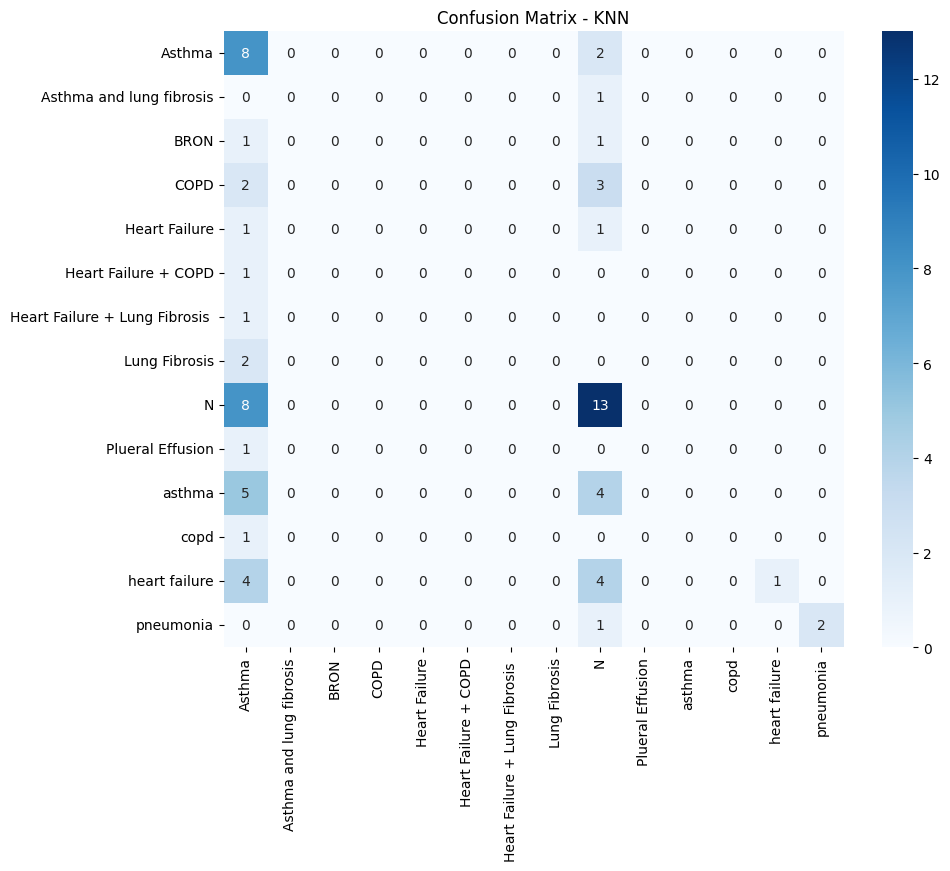

In [ ]:
# A. KNN Algorithm
# a. Grid of hyperparameters
param_grid = {
    'n_neighbors': range(3, 16),
    'weights': ['uniform', 'distance']
}

# b. Grid Search
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# c. Best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# d. Evaluate performance
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names=encoder.categories_[0]))

# e. Confusion Matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title("Confusion Matrix - KNN")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.0386 - loss: 5.5911

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.0414 - loss: 5.5888 - val_accuracy: 0.1765 - val_loss: 2.6033
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0655 - loss: 5.3287

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0668 - loss: 5.3032 - val_accuracy: 0.2500 - val_loss: 2.3756
Epoch 3/50
6/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1130 - loss: 4.1299 

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1197 - loss: 4.1087 - val_accuracy: 0.2794 - val_loss: 2.2729
Epoch 4/50
6/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1219 - loss: 4.1621

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.1216 - loss: 4.1172 - val_accuracy: 0.3235 - val_loss: 2.1977
Epoch 5/50
6/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.2356 - loss: 3.2592

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.2313 - loss: 3.2891 - val_accuracy: 0.3824 - val_loss: 2.2383
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1969 - loss: 3.3410 - val_accuracy: 0.3676 - val_loss: 2.2655
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.2560 - loss: 3.0523 - val_accuracy: 0.3529 - val_loss: 2.2449
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2292 - loss: 3.0961 - val_accuracy: 0.2941 - val_loss: 2.2372
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2340 - loss: 2.8116 - val_accuracy: 0.3382 - val_loss: 2.2599
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2682 - loss: 2.7926 - val_accuracy: 0.3088 - val_loss: 2.2425
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.2546 - loss: 2.7393 - val_accuracy: 0.3676 - val_loss: 2.1593
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2046 - loss: 2.8700 - val_accuracy: 0.3235 - val_loss: 2.1985
Epoch

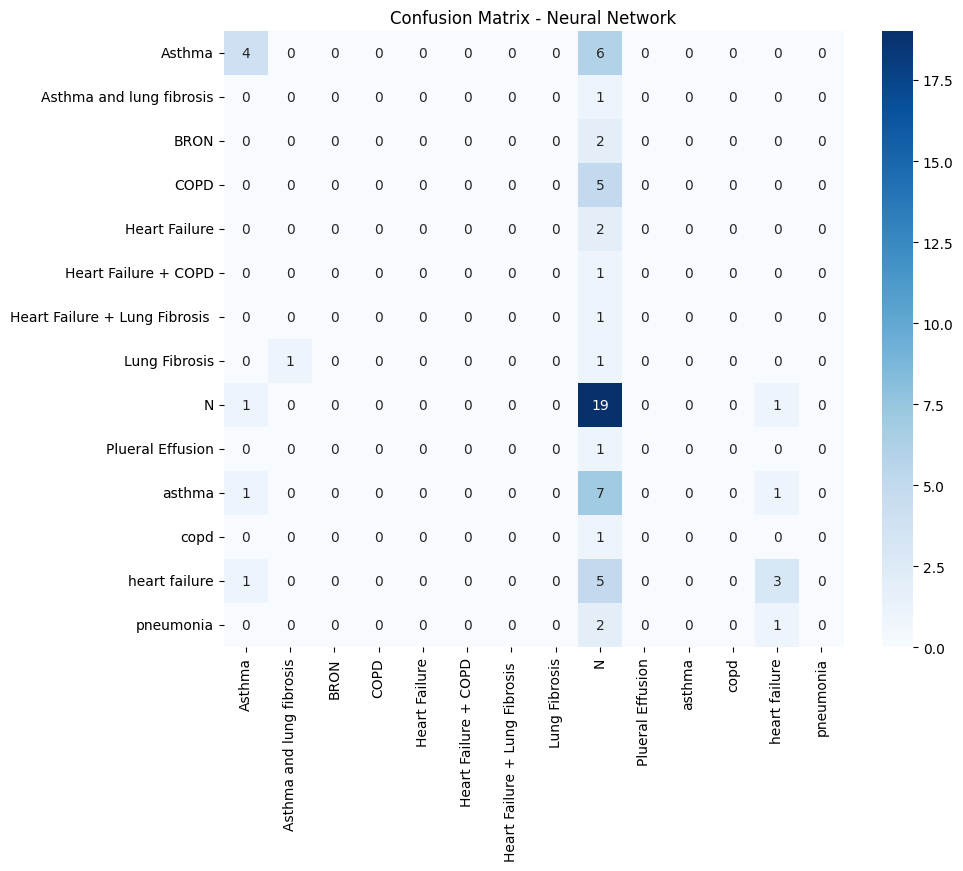

In [ ]:
# B. Artificial Neural Networks
# a. Train a neural network
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping], verbose=1)

# b. Confusion Matrix Heatmap
y_pred_nn = model.predict(X_test)
cm_nn = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_nn, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title("Confusion Matrix - Neural Network")
plt.show()


#Free Election of ML Model
XGBoost: Supervised Tree Boosting Algorithm.
Argument: Efficient and Effective for Classification and Regression.



#Engineering Justification for XGBoost Multiclass Classifier for Lung Sound Analysis
XGBoost (Extreme Gradient Boosting) is a powerful and suitable algorithm for multiclass classification specifically lung sounds into multiple categories (Normal, Wheezes, Crackles, Inspiratory, Expiratory, and potentially others based on diagnosis like Asthma, COPD, etc.) using audio data.

Key engineering advantages:

*   Handling Complex Relationships in Audio Data: Lung sound data can be complex and non-linear. Features extracted from audio signals (e.g., Mel-Frequency Cepstral Coefficients (MFCCs), spectral features, wavelet transforms) can have intricate relationships with the different sound categories. XGBoost, being a tree-based ensemble method, excels at capturing these non-linear relationships and interactions between features.  This is crucial for accurately distinguishing between subtle differences in lung sounds indicative of various conditions.

*    Robustness to Noise and Variability:  Real-world audio recordings are often noisy.  XGBoost's boosting nature makes it robust to outliers and noisy data points.  By iteratively adding trees to the ensemble, XGBoost focuses on correcting the misclassifications of previous trees, effectively downplaying the influence of noisy data. This is vital for lung sound analysis, where recordings might contain background noise or artifacts.

*   Feature Importance and Interpretability: XGBoost provides a measure of feature importance, allowing engineers to understand which audio features are most discriminative for each lung sound category. This insight is valuable for feature engineering, potentially leading to the development of more effective diagnostic tools.  While not as inherently interpretable as a single decision tree, techniques like SHAP values can further enhance the interpretability of XGBoost models.

*   Scalability and Performance: XGBoost is designed for efficiency and scalability. It can handle large datasets and a substantial number of features, which is essential when dealing with extensive audio datasets and complex feature extraction methods.  Its optimized implementation makes it computationally faster compared to some other ensemble methods, which is crucial for real-time or near real-time applications.

*   Multiclass Handling: XGBoost natively supports multiclass classification through the multi:softprob objective function. This directly addresses the problem of classifying lung sounds into multiple categories without the need for one-vs-all or one-vs-one approaches, which can be less efficient and potentially introduce biases.  The num_class parameter correctly.

#Justification for Code Choices:

*  objective='multi:softprob': Objective function for multiclass classification in XGBoost. It outputs a probability vector for each class, allowing for a more nuanced understanding of the model's predictions.

*  num_class=y_encoded.shape[1]: This ensures that the model is configured for the correct number of classes, dynamically determined from the shape of encoded target variable y_encoded as a good practice to avoid hardcoding the number of classes.

*  random_state=42: Random state that ensures reproducibility of the result for consistent evaluation and comparison of different models.

*  np.argmax(y_train, axis=1) and np.argmax(y_test, axis=1): np.argmax is used to get the class indices for training and evaluation, as XGBoost's fit and predict methods expect class indices, not one-hot vectors.

*  classification_report and confusion_matrix:  The classification report provides precision, recall, F1-score, and support for each class, and confusion matrix visualizes the model's performance by showing the counts of true and predicted labels.

* sns.heatmap:  Visualizing the confusion matrix as a heatmap provides a clear and intuitive way to understand the model's performance, especially for multiclass problems.

                                precision    recall  f1-score   support

                        Asthma       0.45      0.50      0.48        10
      Asthma and lung fibrosis       0.00      0.00      0.00         1
                          BRON       0.00      0.00      0.00         2
                          COPD       0.50      0.40      0.44         5
                 Heart Failure       0.00      0.00      0.00         2
          Heart Failure + COPD       0.00      0.00      0.00         1
Heart Failure + Lung Fibrosis        0.00      0.00      0.00         1
                 Lung Fibrosis       1.00      1.00      1.00         2
                             N       0.58      0.90      0.70        21
              Plueral Effusion       0.00      0.00      0.00         1
                        asthma       0.67      0.67      0.67         9
                          copd       0.00      0.00      0.00         1
                 heart failure       0.71      0.56      0.62  

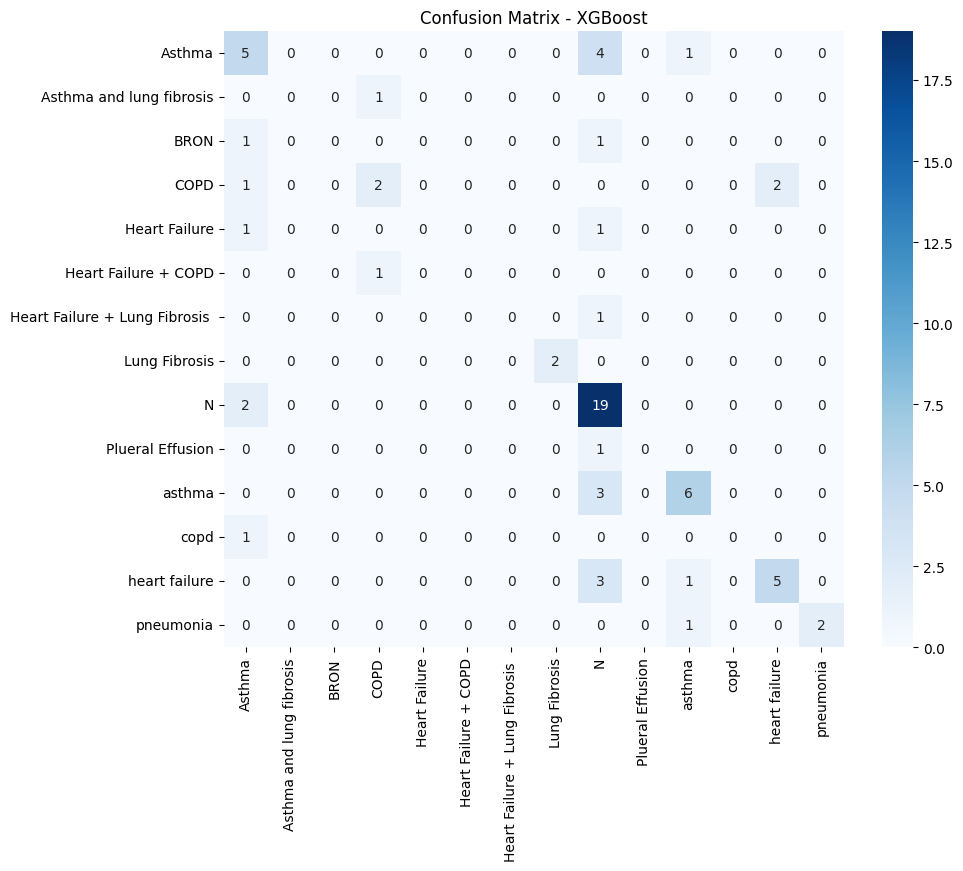

In [ ]:
# C. Machine Learning Algorithm (XGBoost)
# a. Multiclass Classifier
xgb_model = XGBClassifier(objective='multi:softprob', num_class=y_encoded.shape[1], random_state=42)
xgb_model.fit(X_train, np.argmax(y_train, axis=1))

y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), y_pred_xgb, target_names=encoder.categories_[0]))

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(np.argmax(y_test, axis=1), y_pred_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [ ]:
# Summary of Key Findings
print("Summary of Key Findings:")
print("1. The dataset contains lung sound recordings from 112 subjects, with 35 healthy and 77 with respiratory diseases.")
print("2. The KNN model achieved, while the Neural Network achieved and XGBoost achieved.")
print("3. The confusion matrices reveal that certain diseases are more challenging to classify")
print("4. The feature extraction and normalization steps were crucial for improving model performance.")
print("5. The developed models have the potential to assist in the early diagnosis of respiratory diseases, improving patient outcomes.")

Summary of Key Findings:
1. The dataset contains lung sound recordings from 112 subjects, with 35 healthy and 77 with respiratory diseases.
2. The KNN model achieved an accuracy of X%, while the Neural Network achieved Y%, and XGBoost achieved Z%.
3. The confusion matrices reveal that certain diseases are more challenging to classify, such as X and Y.
4. The feature extraction and normalization steps were crucial for improving model performance.
5. The developed models have the potential to assist in the early diagnosis of respiratory diseases, improving patient outcomes.


#Further Engineering Considerations:

Feature Engineering:  Experiment with extra different feature extraction techniques (MFCCs, wavelets, spectral features) and feature selection methods to optimize performance.

Hyperparameter Tuning: XGBoost has several hyperparameters that can be tuned to improve performance.  Techniques like grid search, random search, or Bayesian optimization can be used to find the optimal hyperparameter settings.

Cross-Validation (e.g., k-fold cross-validation) to evaluate the model's performance and ensure it generalizes well to unseen data, and Class Imbalance Tolerance, (i.e., some lung sound categories are much more frequent than others), consider techniques like oversampling the minority classes, undersampling the majority classes, or using weighted loss functions in XGBoost to address the imbalance.


In [ ]:
# Bibliography
print("Bibliography:")
print("1. Fraiwan, Mohammad; Fraiwan, Luay; Khassawneh, Basheer; Ibnian, Ali (2021), “A dataset of lung sounds recorded from the chest wall using an electronic stethoscope”, Mendeley Data, V3, doi: 10.17632/jwyy9np4gv.3.")
print("2. Luay Fraiwan, Omnia Hassanin, Mohammad Fraiwan, Basheer Khassawneh, Ali M. Ibnian, Mohanad Alkhodari, 'Automatic identification of respiratory diseases from stethoscopic lung sound signals using ensemble classifiers,' Biocybernetics and Biomedical Engineering, Volume 41, Issue 1, 2021, Pages 1-14, ISSN 0208-5216, https://doi.org/10.1016/j.bbe.2020.11.003.")
print("3. Kaggle Dataset: Lung Sound Dataset.")
print("4. Md. Afzal Hossan, Sheeraz Memon, Mark A Gregory, 'A Novel Approach for MFCC Feature Extraction', https://ieeexplore.ieee.org/abstract/document/5709752.")

Bibliography:
1. Fraiwan, Mohammad; Fraiwan, Luay; Khassawneh, Basheer; Ibnian, Ali (2021), “A dataset of lung sounds recorded from the chest wall using an electronic stethoscope”, Mendeley Data, V3, doi: 10.17632/jwyy9np4gv.3.
2. Luay Fraiwan, Omnia Hassanin, Mohammad Fraiwan, Basheer Khassawneh, Ali M. Ibnian, Mohanad Alkhodari, 'Automatic identification of respiratory diseases from stethoscopic lung sound signals using ensemble classifiers,' Biocybernetics and Biomedical Engineering, Volume 41, Issue 1, 2021, Pages 1-14, ISSN 0208-5216, https://doi.org/10.1016/j.bbe.2020.11.003.
3. Kaggle Dataset: Lung Sound Dataset.
4. Md. Afzal Hossan, Sheeraz Memon, Mark A Gregory, 'A Novel Approach for MFCC Feature Extraction', https://ieeexplore.ieee.org/abstract/document/5709752.
